In [6]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from datasets import load_metric
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np
import random
from pytorch_lightning.callbacks import ModelCheckpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [69]:
class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, feature_extractor):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annota SegformerForSemanticSegmentationtions.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor

        self.classes_csv_file = os.path.join(self.root_dir, "_classes.csv")
        self.classes_csv_file = os.path.join(self.root_dir, "_classes.csv")
        with open(self.classes_csv_file, 'r') as fid:
            data = [l.split(',') for i,l in enumerate(fid) if i !=0]
        self.id2label = {x[0]:x[1] for x in data}

        image_file_names = [f for f in os.listdir(self.root_dir) if '.jpg' in f]
        mask_file_names = [f for f in os.listdir(self.root_dir) if '.gif' in f]

        self.images = sorted(image_file_names)
        self.masks = sorted(mask_file_names)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = np.array(Image.open(os.path.join(self.root_dir, self.images[idx])).convert("RGB"))
        segmentation_map = np.array(Image.open(os.path.join(self.root_dir, self.masks[idx])).convert("L"), dtype=np.float32)
        segmentation_map[segmentation_map == 255] = 1.0
        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

In [70]:
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/mit-b0")
feature_extractor.reduce_labels = False
feature_extractor.size = 160
dataset_path = "/home/ubuntu/work/carvana/segFormer"
train_dataset = SemanticSegmentationDataset(f"{dataset_path}/train/", feature_extractor)
val_dataset = SemanticSegmentationDataset(f"{dataset_path}/valid/", feature_extractor)
test_dataset = SemanticSegmentationDataset(f"{dataset_path}/test/", feature_extractor)

/opt/conda/envs/pytorch/lib/python3.10/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [50]:
from transformers import SegformerForSemanticSegmentation
import json
from huggingface_hub import hf_hub_download

# load id2label mapping from a JSON on the hub
repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(hf_hub_download(repo_id=repo_id, filename=filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

# define model
# modelName = "nvidia/mit-b0"
modelName = "doc2txt/segFormerTst"
model = SegformerForSemanticSegmentation.from_pretrained(modelName,
                                                         return_dict=True,
                                                        #  num_labels=150,
                                                        #  id2label=id2label,
                                                        #  label2id=label2id,
)
model = model.to(device)

In [73]:
color_map = {
    0:(0,0,0),
    1:(255,0,0),
}

def prediction_to_vis(prediction):
    vis_shape = prediction.shape + (3,)
    vis = np.zeros(vis_shape)
    for i,c in color_map.items():
        vis[prediction == i] = color_map[i]
    return Image.fromarray(vis.astype(np.uint8))


    

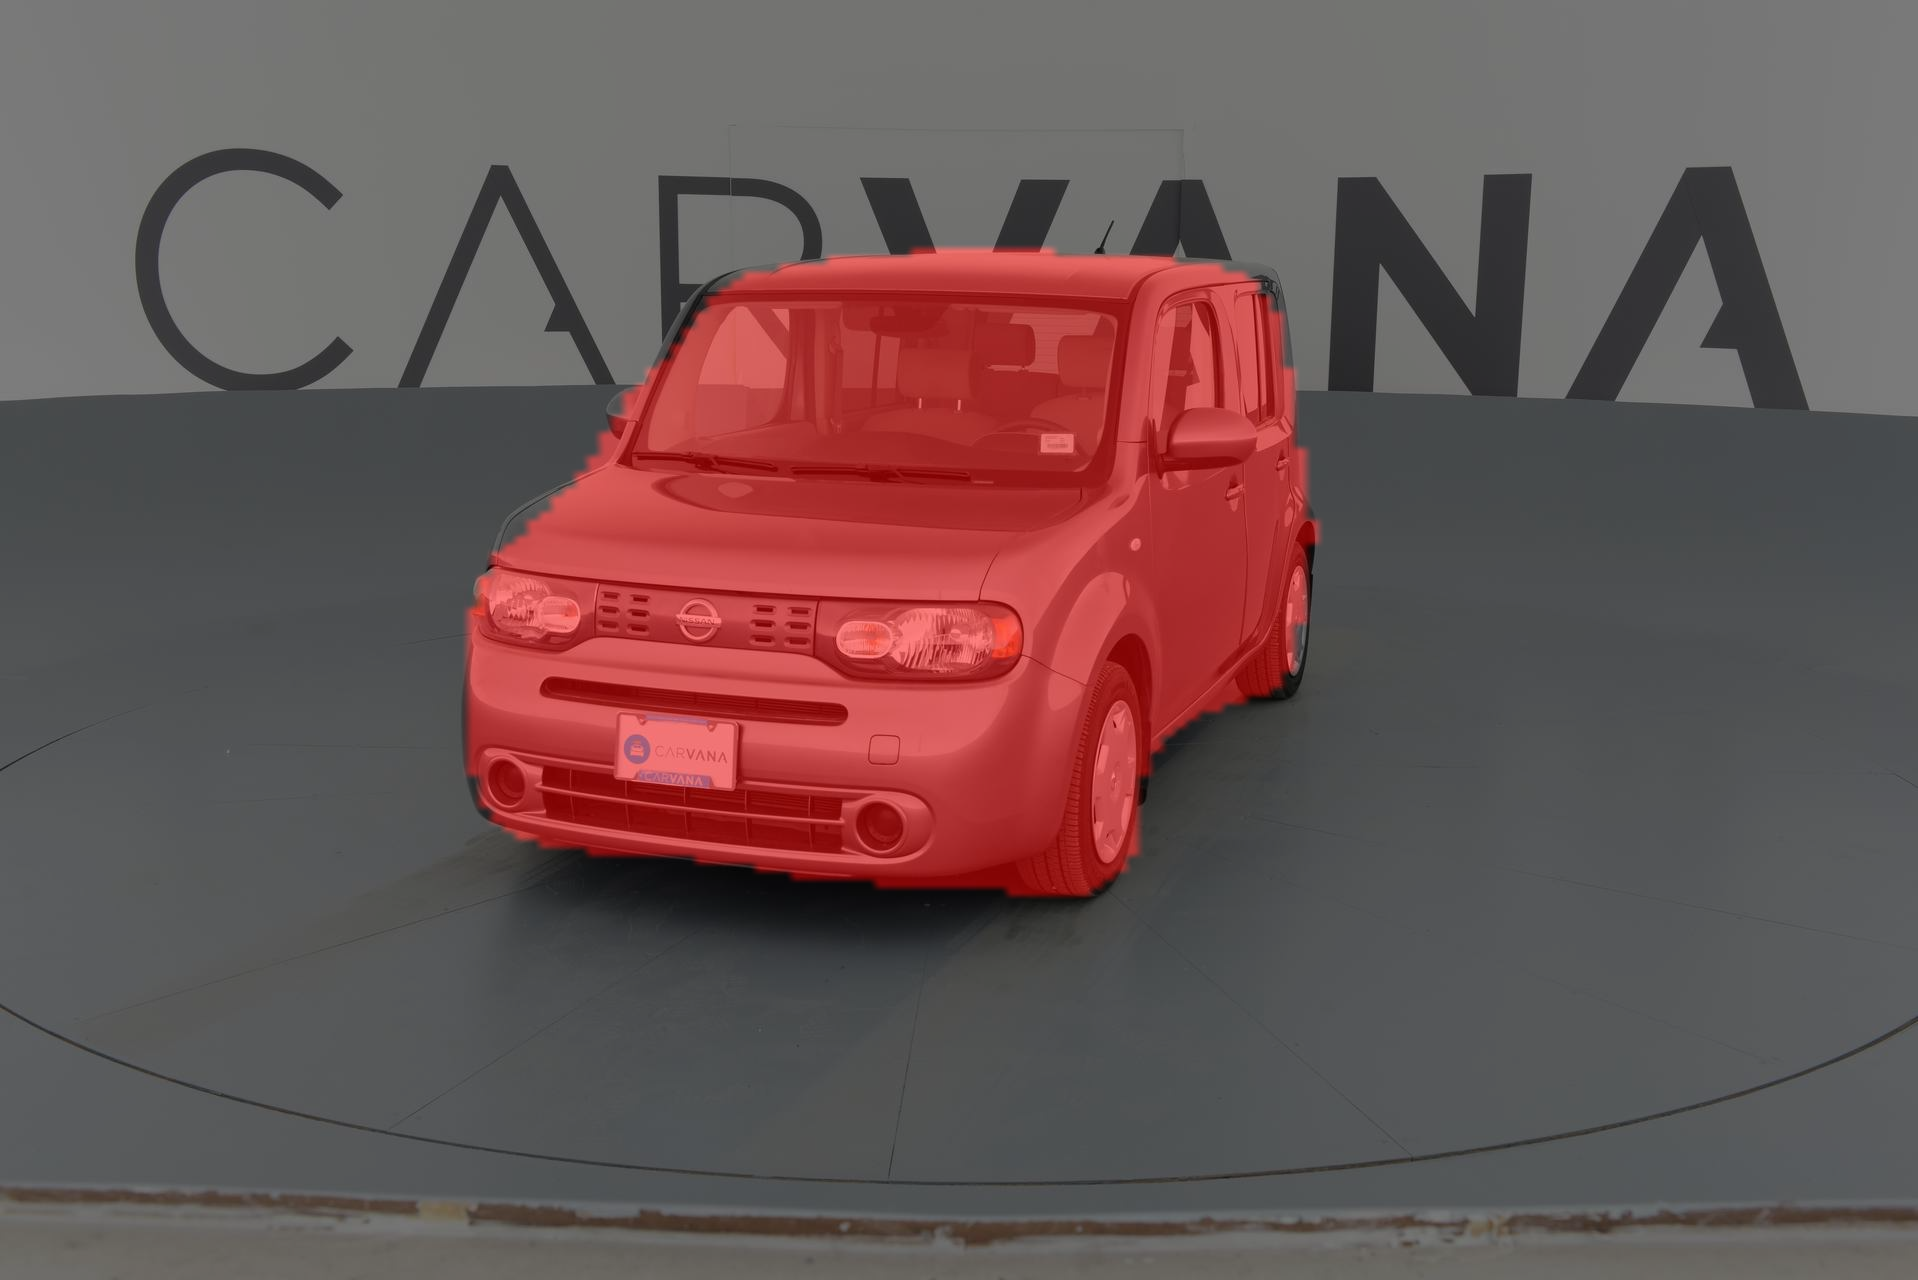

In [78]:
#Predict on a test image and overlay the mask on the original image
test_idx = 1
input_image_file = os.path.join(test_dataset.root_dir,test_dataset.images[test_idx])
input_image = Image.open(input_image_file)
test_batch = test_dataset[test_idx]
images, masks = test_batch['pixel_values'], test_batch['labels']
images = torch.unsqueeze(images, 0).to(device)
outputs = model(images)

logits = outputs.logits

upsampled_logits = nn.functional.interpolate(
    logits,
    size=masks.shape[-2:],
    mode="bilinear",
    align_corners=False
)
predicted_mask = upsampled_logits.argmax(dim=1).cpu().numpy()
mask = prediction_to_vis(np.squeeze(predicted_mask))
mask = mask.resize(input_image.size)
mask = mask.convert("RGBA")
input_image = input_image.convert("RGBA")
overlay_img = Image.blend(input_image, mask, 0.5)
overlay_img